## 스마트 정수장 알고리즘 - 약품 공정 - EDA

In [1]:
import numpy as np
import pandas as pd
import datetime
import scipy
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pickle
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

if platform.system() == "Darwin":  #
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="NanumGothic")

fe = fm.FontEntry(
    fname=r"/usr/share/fonts/truetype/nanum/NanumGothic.ttf",  # ttf 파일이 저장되어 있는 경로
    name="NanumGothic",
)  # 원하는 폰트 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가

plt.rcParams.update({"font.size": 18, "font.family": "NanumGothic"})  # 폰트 설정

plt.rcParams["axes.unicode_minus"] = False

---
### 문제 정의
> 데이터 분석을 수행하기 위해서는 해결하려는 문제가 무엇인지 정의되어야 한다. </br>
> 분석하고자 하는 분야를 이해하고 구체적으로 문제를 정의한다.

**약품 공정의 목적** </br>
응집$\cdot$침전 공정은 여과 공정 이전에 일차적으로 탁질을 제거하여 응집지의 폐색을 늦추고 안정적인 운영을 가능하도록 한다. </br>
약품 공정에서는 응집$\cdot$침전 공정이 효과적으로 작동할 수 있도록 적절한 응집제 및 알칼리제를 주입한다. </br>
약품 공정이 잘 작동되었는지를 확인하려면 침전지 탁도가 안정적으로 유지되는지로 판단할 수 있다.

**약품 공정 AI 알고리즘의 목표** </br>
근무자의 결정을 모사하여 적절한 응집제 주입률을 구하는 것이 목표이다.

---
### 1.2. 데이터 정의
> 앞서 정의한 문제에 의거하여 필요한 데이터를 정의하고, 해당 데이터를 수집하는 단계이다.

#### 1.2.1. 필요 데이터

근무자의 결정을 모사하는 것이 목표이기 때문에, 근무자의 주입률 결정 방법을 이해해야 한다. </br>
기존에 사용되던 근무자의 결정 방법은 다음과 같다. </br>

**응집제 주입률 결정 방법** </br>
- 탁도에 따라 조견표로 응집제 주입률 결정 </br>
- 탁도, pH, 알칼리도와 같은 수질 인자로부터 경험적으로 응집제 주입률 결정 </br>
- 시네드라와 같은 조류 발생 시 여과지 폐색을 줄이기 위해 강화 응집 </br>
- 청소나 점검과 같은 이유로 일부 침전지, 여과지를 사용하지 않을 시 강화 응집 </br>
- 여름철 태풍과 같이 강우가 내릴 때 강화 응집 </br>

이때 강우가 내리는 것은 원수의 탁도, 알칼리도 등으로 확인할 수 있다.

따라서 필요한 데이터는 다음과 같다.</br>

**필요 데이터**
- 탁도, pH, 알칼리도, 전기전도도, 수온, 망간과 같은 원수 수질 인자
- 사용하고 있는 침전지 지수와 여과지 지수, 체류시간
- 시네드라의 발생 여부 및 발생 조건
- 응집제 주입률
- 침전지 탁도

#### 1.2.2. 수집 데이터

In [2]:
file = "SN_2020.csv"
load_df = pd.read_csv(file)
load_df.head(5)

,시간,원수 알칼리도,원수 전기전도도,원수 pH,원수 탁도,원수 수온,3단계 원수 유입 유량,4단계 원수 유입 유량,3단계 1계열 응집제 주입량,3단계 1계열 응집제 주입률,...,4단계 2번 약품 주입기 주입률 제어값,4단계 2계열 약품 주입기 ON,3단계 혼화수 pH,4단계 혼화수 pH,3단계 침전지 탁도,4단계 침전지 탁도 1,여과지 탁도,3단계 회수 유량,4단계 회수 유량,4단계 침전지 탁도 2
0,2020-01-01 09:01:00,53.77500,219.8438,8.261750,2.568750,4.60625,8357.50,8952.50,933.3333,13.39897,...,13.0,1.0,7.877625,7.753375,0.255000,0.361375,0.045375,1.35000,0.0000,0.325332
1,2020-01-01 09:02:00,53.68125,219.4375,8.258250,2.631250,4.60000,8408.75,8928.75,933.3333,13.31705,...,13.0,1.0,7.872375,7.742875,0.249375,0.365625,0.050750,1.51875,0.0000,0.329158
2,2020-01-01 09:03:00,53.68750,219.8438,8.258250,2.618750,4.60000,8386.25,8970.00,933.3333,13.33714,...,13.0,1.0,7.871500,7.747250,0.251875,0.363625,0.051250,1.35000,0.0000,0.327358
3,2020-01-01 09:04:00,53.68750,220.0000,8.255625,2.609375,4.60625,8346.25,9075.00,933.3333,13.63389,...,13.0,1.0,7.875875,7.745500,0.251250,0.357125,0.046625,1.01250,0.0000,0.321506
4,2020-01-01 09:05:00,53.71875,219.8438,8.253000,2.581250,4.61875,8338.75,9038.75,933.3333,12.38729,...,13.0,1.0,7.868000,7.739375,0.250625,0.362750,0.054250,746.88750,970.4688,0.326570


In [3]:
load_df = load_df.set_index("시간")
load_df.index = pd.DatetimeIndex(load_df.index)
load_df.head(5)

,원수 알칼리도,원수 전기전도도,원수 pH,원수 탁도,원수 수온,3단계 원수 유입 유량,4단계 원수 유입 유량,3단계 1계열 응집제 주입량,3단계 1계열 응집제 주입률,3단계 1번 약품 주입기 주입률 제어값,...,4단계 2번 약품 주입기 주입률 제어값,4단계 2계열 약품 주입기 ON,3단계 혼화수 pH,4단계 혼화수 pH,3단계 침전지 탁도,4단계 침전지 탁도 1,여과지 탁도,3단계 회수 유량,4단계 회수 유량,4단계 침전지 탁도 2
시간,,,,,,,,,,,,,,,,,,,,,
2020-01-01 09:01:00,53.77500,219.8438,8.261750,2.568750,4.60625,8357.50,8952.50,933.3333,13.39897,13.35,...,13.0,1.0,7.877625,7.753375,0.255000,0.361375,0.045375,1.35000,0.0000,0.325332
2020-01-01 09:02:00,53.68125,219.4375,8.258250,2.631250,4.60000,8408.75,8928.75,933.3333,13.31705,13.35,...,13.0,1.0,7.872375,7.742875,0.249375,0.365625,0.050750,1.51875,0.0000,0.329158
2020-01-01 09:03:00,53.68750,219.8438,8.258250,2.618750,4.60000,8386.25,8970.00,933.3333,13.33714,13.35,...,13.0,1.0,7.871500,7.747250,0.251875,0.363625,0.051250,1.35000,0.0000,0.327358
2020-01-01 09:04:00,53.68750,220.0000,8.255625,2.609375,4.60625,8346.25,9075.00,933.3333,13.63389,13.35,...,13.0,1.0,7.875875,7.745500,0.251250,0.357125,0.046625,1.01250,0.0000,0.321506
2020-01-01 09:05:00,53.71875,219.8438,8.253000,2.581250,4.61875,8338.75,9038.75,933.3333,12.38729,13.35,...,13.0,1.0,7.868000,7.739375,0.250625,0.362750,0.054250,746.88750,970.4688,0.326570


In [4]:
cols = [
    "원수 탁도",
    "원수 pH",
    "원수 알칼리도",
    "원수 전기전도도",
    "원수 수온",
    "3단계 원수 유입 유량",
    "3단계 1계열 응집제 주입률",
    "3단계 침전지 탁도",
]
raw_df = load_df[cols]
raw_df.head(5)

,원수 탁도,원수 pH,원수 알칼리도,원수 전기전도도,원수 수온,3단계 원수 유입 유량,3단계 1계열 응집제 주입률,3단계 침전지 탁도
시간,,,,,,,,
2020-01-01 09:01:00,2.568750,8.261750,53.77500,219.8438,4.60625,8357.50,13.39897,0.255000
2020-01-01 09:02:00,2.631250,8.258250,53.68125,219.4375,4.60000,8408.75,13.31705,0.249375
2020-01-01 09:03:00,2.618750,8.258250,53.68750,219.8438,4.60000,8386.25,13.33714,0.251875
2020-01-01 09:04:00,2.609375,8.255625,53.68750,220.0000,4.60625,8346.25,13.63389,0.251250
2020-01-01 09:05:00,2.581250,8.253000,53.71875,219.8438,4.61875,8338.75,12.38729,0.250625


---
### 1.3. 탐색적 데이터 분석 (EDA)

#### 1.3.1. 통계값 확인

In [5]:
raw_df.describe()

,원수 탁도,원수 pH,원수 알칼리도,원수 전기전도도,원수 수온,3단계 원수 유입 유량,3단계 1계열 응집제 주입률,3단계 침전지 탁도
count,502646.000000,510294.000000,5.103050e+05,510303.000000,502646.000000,510295.000000,510306.000000,502646.000000
mean,10.252908,7.935648,5.754057e+01,188.898851,14.965538,11407.945492,18.041812,0.409374
std,23.392446,0.491832,6.942874e+03,29.287604,7.328783,1348.036734,7.155386,0.167153
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.221875,7.638750,4.261875e+01,169.968800,7.525000,10522.500000,14.155010,0.306875
50%,4.681250,7.845250,4.725000e+01,191.625000,15.231250,11653.750000,15.699905,0.377500
75%,6.812500,8.237250,5.301875e+01,210.437500,21.850000,12393.750000,19.620513,0.466250
max,344.562500,9.230375,4.959730e+06,260.468800,27.456250,20000.000000,100.000000,10.000000


In [6]:
mean = raw_df.mean()
mean

원수 탁도                 10.252908
원수 pH                  7.935648
원수 알칼리도               57.540565
원수 전기전도도             188.898851
원수 수온                 14.965538
3단계 원수 유입 유량       11407.945492
3단계 1계열 응집제 주입률       18.041812
3단계 침전지 탁도             0.409374
dtype: float64

In [7]:
std = raw_df.std()
std

원수 탁도                23.392446
원수 pH                 0.491832
원수 알칼리도            6942.873808
원수 전기전도도             29.287604
원수 수온                 7.328783
3단계 원수 유입 유량       1348.036734
3단계 1계열 응집제 주입률       7.155386
3단계 침전지 탁도            0.167153
dtype: float64

#### 1.3.2. 시계열 차트

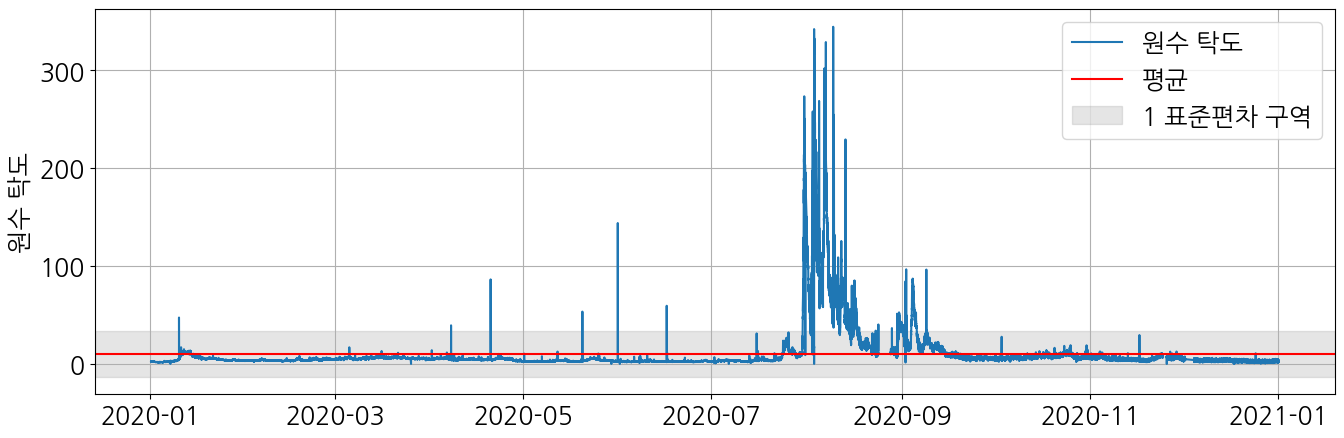

In [8]:
fig = plt.figure(figsize=(16, 5))
plt.plot(raw_df.index, raw_df["원수 탁도"], label="원수 탁도")
plt.axhline(mean["원수 탁도"], c="r", label="평균")
plt.axhspan(
    mean["원수 탁도"] - std["원수 탁도"],
    mean["원수 탁도"] + std["원수 탁도"],
    color="grey",
    alpha=0.2,
    label="1 표준편차 구역",
)
plt.ylabel("원수 탁도")
plt.grid()
plt.legend()

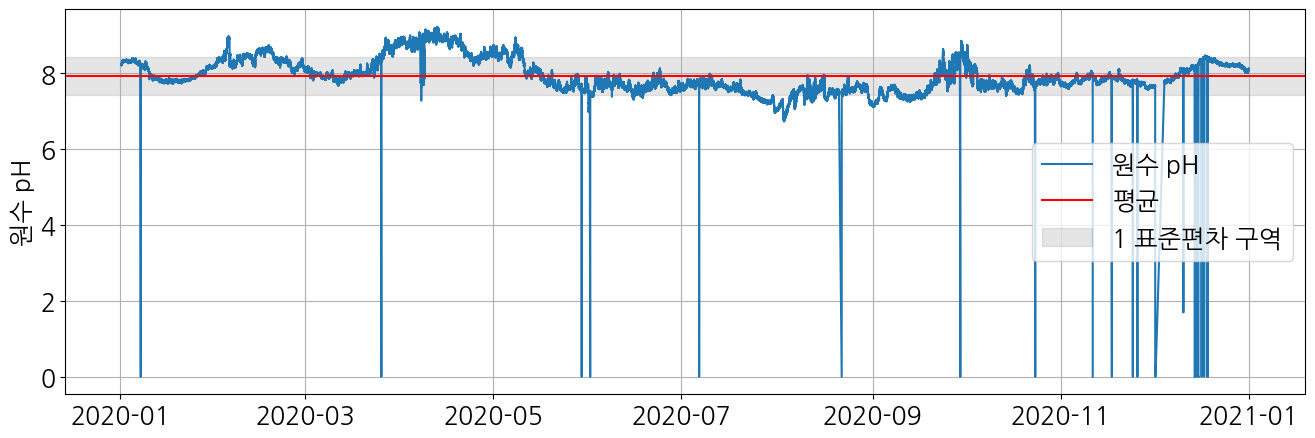

In [9]:
col = "원수 pH"
fig = plt.figure(figsize=(16, 5))
plt.plot(raw_df.index, raw_df[col], label=col)
plt.axhline(mean[col], c="r", label="평균")
plt.axhspan(
    mean[col] - std[col],
    mean[col] + std[col],
    color="grey",
    alpha=0.2,
    label="1 표준편차 구역",
)
plt.ylabel(col)
plt.grid()
plt.legend()

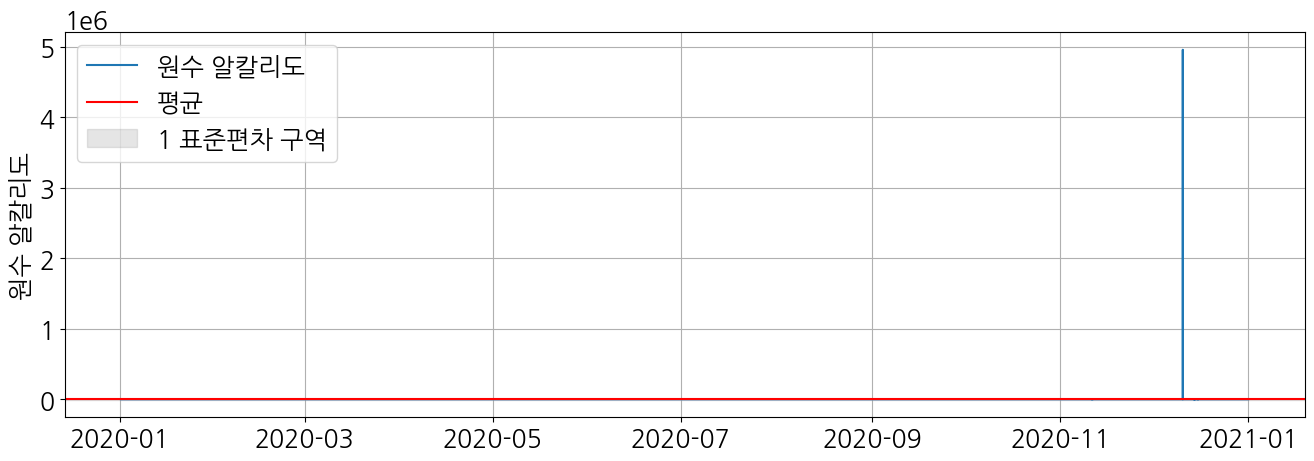

In [10]:
col = "원수 알칼리도"
fig = plt.figure(figsize=(16, 5))
plt.plot(raw_df.index, raw_df[col], label=col)
plt.axhline(mean[col], c="r", label="평균")
plt.axhspan(
    mean[col] - std[col],
    mean[col] + std[col],
    color="grey",
    alpha=0.2,
    label="1 표준편차 구역",
)
plt.ylabel(col)
plt.grid()
plt.legend()

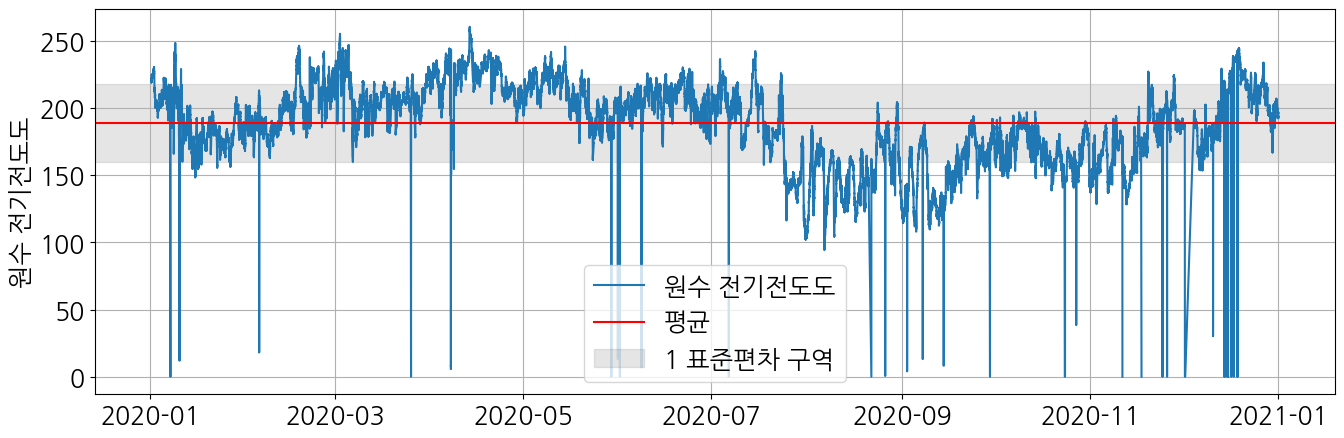

In [11]:
col = "원수 전기전도도"
fig = plt.figure(figsize=(16, 5))
plt.plot(raw_df.index, raw_df[col], label=col)
plt.axhline(mean[col], c="r", label="평균")
plt.axhspan(
    mean[col] - std[col],
    mean[col] + std[col],
    color="grey",
    alpha=0.2,
    label="1 표준편차 구역",
)
plt.ylabel(col)
plt.grid()
plt.legend()

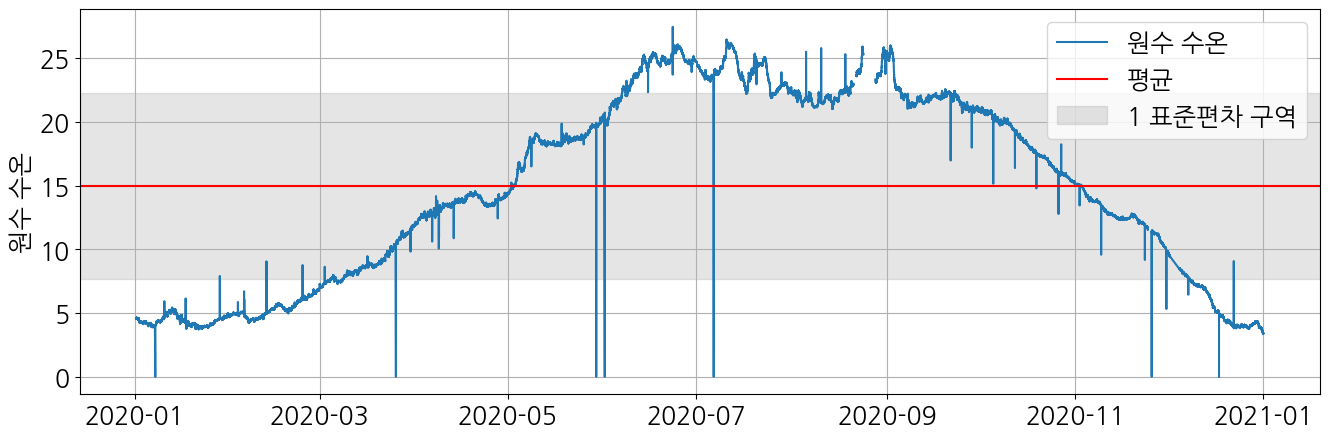

In [12]:
col = "원수 수온"
fig = plt.figure(figsize=(16, 5))
plt.plot(raw_df.index, raw_df[col], label=col)
plt.axhline(mean[col], c="r", label="평균")
plt.axhspan(
    mean[col] - std[col],
    mean[col] + std[col],
    color="grey",
    alpha=0.2,
    label="1 표준편차 구역",
)
plt.ylabel(col)
plt.grid()
plt.legend()

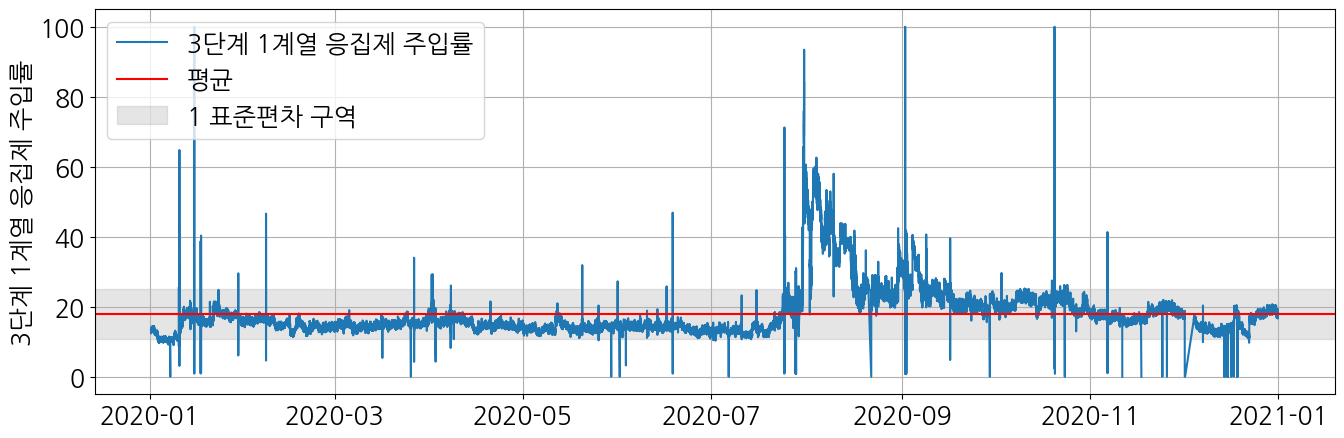

In [13]:
col = "3단계 1계열 응집제 주입률"
fig = plt.figure(figsize=(16, 5))
plt.plot(raw_df.index, raw_df[col], label=col)
plt.axhline(mean[col], c="r", label="평균")
plt.axhspan(
    mean[col] - std[col],
    mean[col] + std[col],
    color="grey",
    alpha=0.2,
    label="1 표준편차 구역",
)
plt.ylabel(col)
plt.grid()
plt.legend()

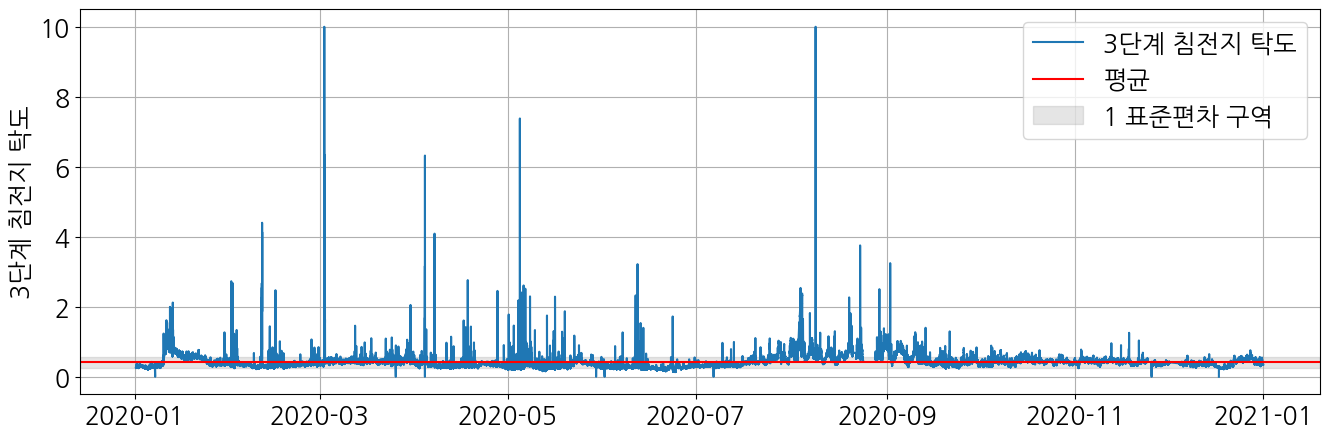

In [14]:
col = "3단계 침전지 탁도"
fig = plt.figure(figsize=(16, 5))
plt.plot(raw_df.index, raw_df[col], label=col)
plt.axhline(mean[col], c="r", label="평균")
plt.axhspan(
    mean[col] - std[col],
    mean[col] + std[col],
    color="grey",
    alpha=0.2,
    label="1 표준편차 구역",
)
plt.ylabel(col)
plt.grid()
plt.legend()

#### 1.3.3. 히스토그램

Text(0, 0.5, '데이터 개수')

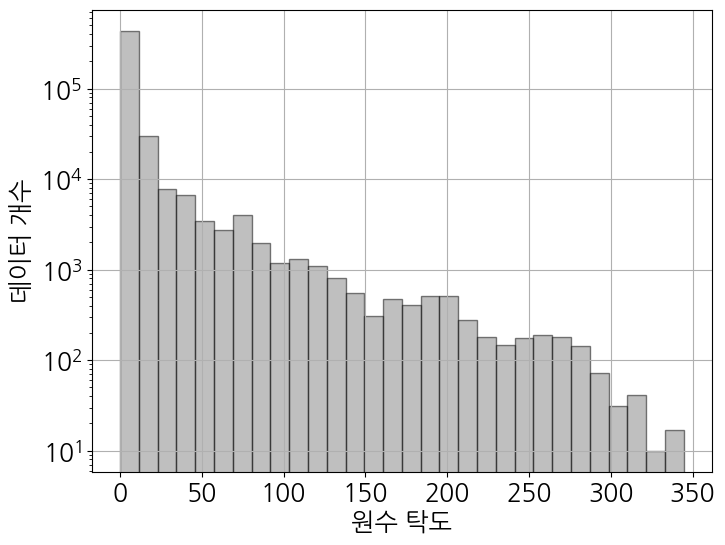

In [15]:
plt.figure(figsize=(8, 6))
plt.hist(raw_df["원수 탁도"], bins=30, facecolor="grey", edgecolor="k", alpha=0.5)
plt.yscale("log")
plt.grid()
plt.xlabel("원수 탁도")
plt.ylabel("데이터 개수")

Text(0, 0.5, '데이터 개수')

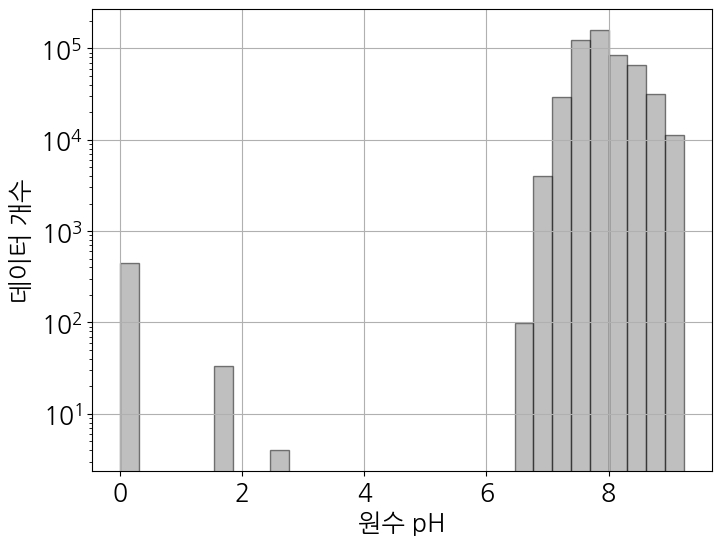

In [16]:
col = "원수 pH"
plt.figure(figsize=(8, 6))
plt.hist(raw_df[col], bins=30, facecolor="grey", edgecolor="k", alpha=0.5)
plt.yscale("log")
plt.grid()
plt.xlabel(col)
plt.ylabel("데이터 개수")

Text(0, 0.5, '데이터 개수')

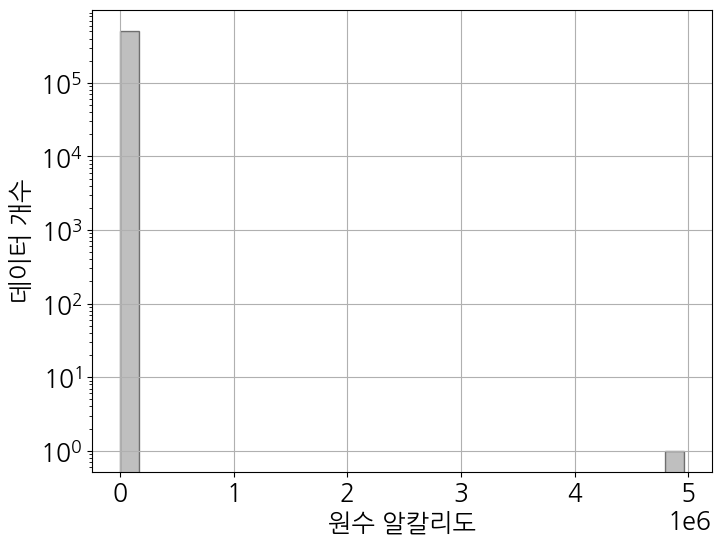

In [17]:
col = "원수 알칼리도"
plt.figure(figsize=(8, 6))
plt.hist(raw_df[col], bins=30, facecolor="grey", edgecolor="k", alpha=0.5)
plt.yscale("log")
plt.grid()
plt.xlabel(col)
plt.ylabel("데이터 개수")

Text(0, 0.5, '데이터 개수')

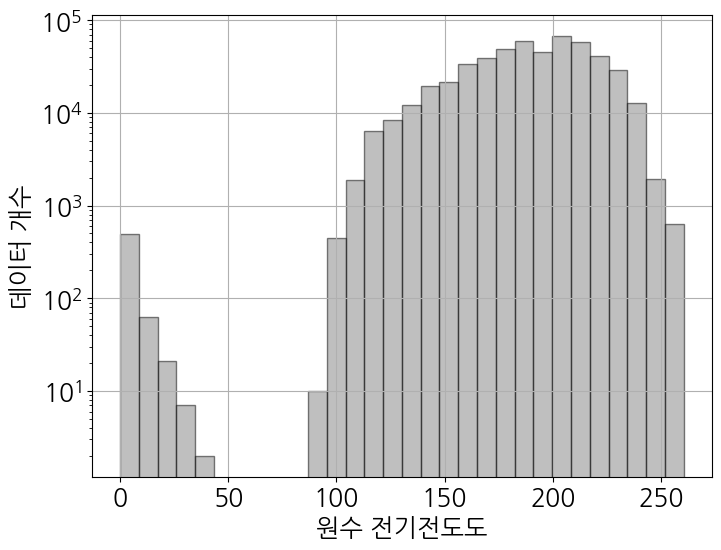

In [18]:
col = "원수 전기전도도"
plt.figure(figsize=(8, 6))
plt.hist(raw_df[col], bins=30, facecolor="grey", edgecolor="k", alpha=0.5)
plt.yscale("log")
plt.grid()
plt.xlabel(col)
plt.ylabel("데이터 개수")

Text(0, 0.5, '데이터 개수')

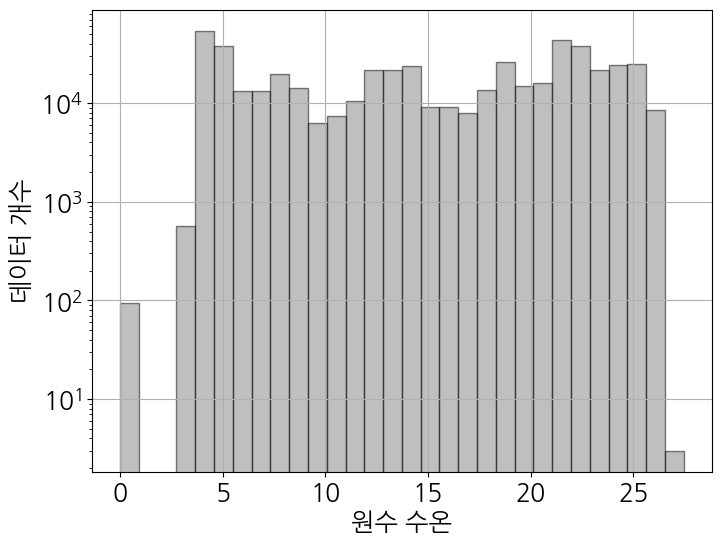

In [19]:
col = "원수 수온"
plt.figure(figsize=(8, 6))
plt.hist(raw_df[col], bins=30, facecolor="grey", edgecolor="k", alpha=0.5)
plt.yscale("log")
plt.grid()
plt.xlabel(col)
plt.ylabel("데이터 개수")

Text(0, 0.5, '데이터 개수')

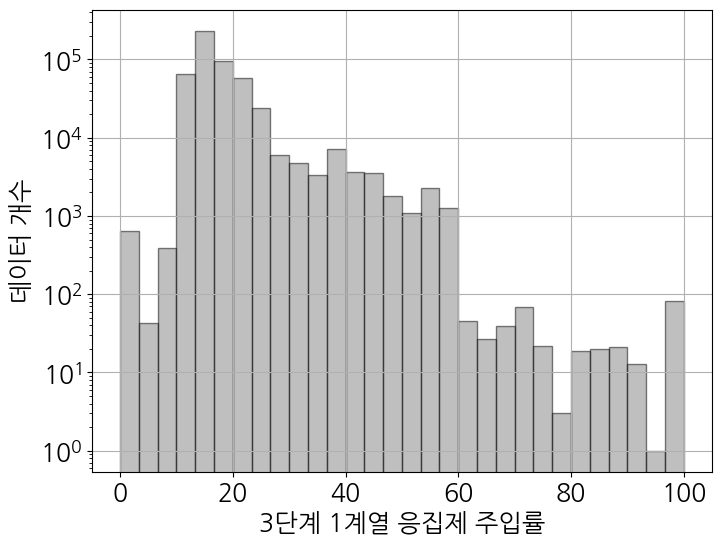

In [20]:
col = "3단계 1계열 응집제 주입률"
plt.figure(figsize=(8, 6))
plt.hist(raw_df[col], bins=30, facecolor="grey", edgecolor="k", alpha=0.5)
plt.yscale("log")
plt.grid()
plt.xlabel(col)
plt.ylabel("데이터 개수")

Text(0, 0.5, '데이터 개수')

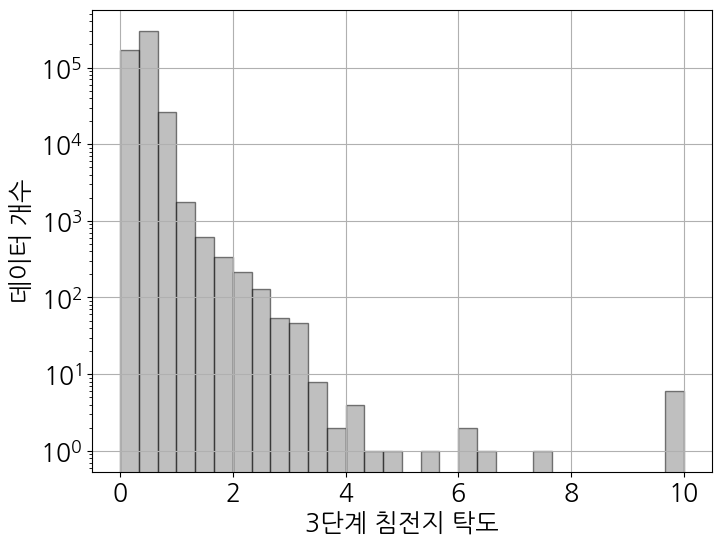

In [21]:
col = "3단계 침전지 탁도"
plt.figure(figsize=(8, 6))
plt.hist(raw_df[col], bins=30, facecolor="grey", edgecolor="k", alpha=0.5)
plt.yscale("log")
plt.grid()
plt.xlabel(col)
plt.ylabel("데이터 개수")

#### 1.3.2. 분산형 차트

Text(0, 0.5, '응집제 주입률')

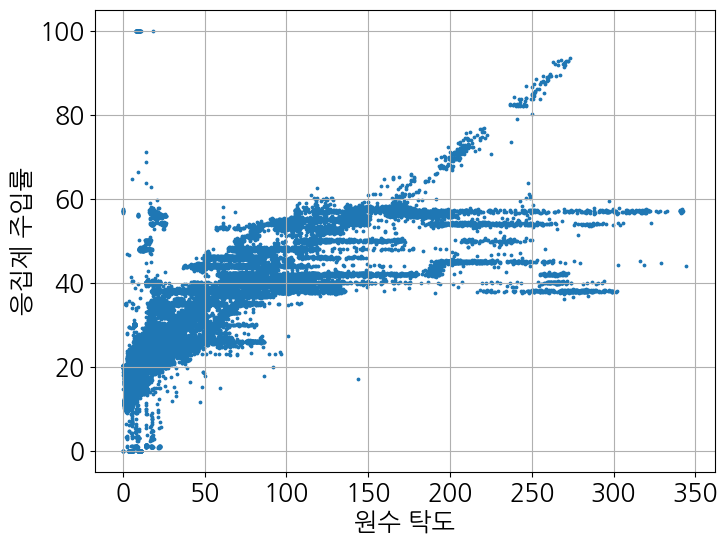

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(raw_df["원수 탁도"], raw_df["3단계 1계열 응집제 주입률"], s=3)
plt.grid()
plt.xlabel("원수 탁도")
plt.ylabel("응집제 주입률")

Text(0, 0.5, '3단계 침전지 탁도')

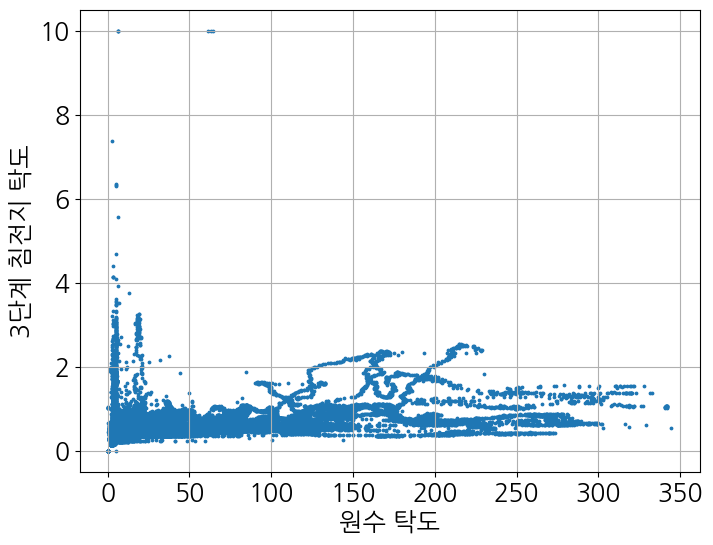

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(raw_df["원수 탁도"], raw_df["3단계 침전지 탁도"], s=3)
plt.grid()
plt.xlabel("원수 탁도")
plt.ylabel("3단계 침전지 탁도")

Text(0, 0.5, '원수 pH')

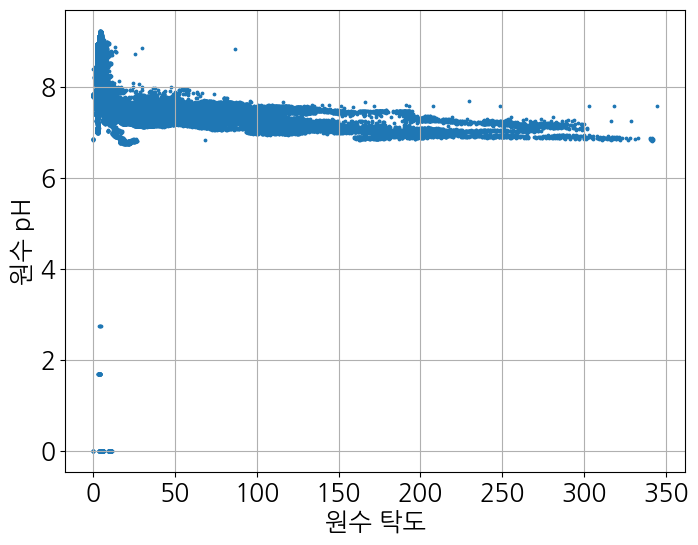

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(raw_df["원수 탁도"], raw_df["원수 pH"], s=3)
plt.grid()
plt.xlabel("원수 탁도")
plt.ylabel("원수 pH")

Text(0, 0.5, '3단계 1계열 응집제 주입률')

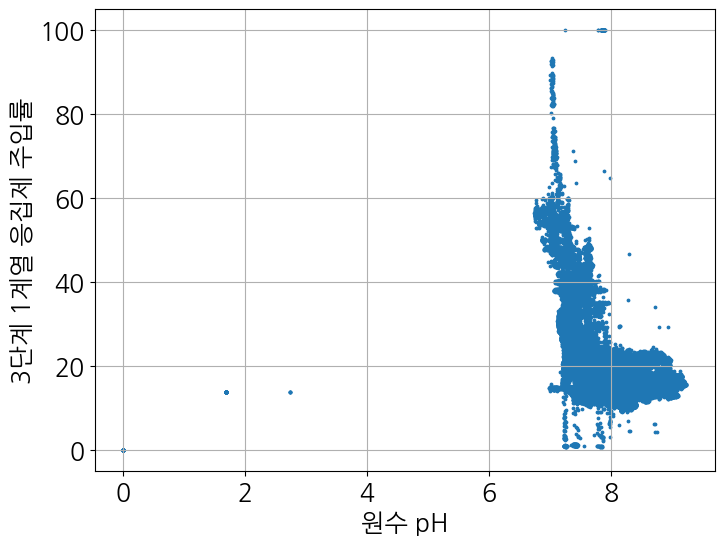

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(raw_df["원수 pH"], raw_df["3단계 1계열 응집제 주입률"], s=3)
plt.grid()
plt.xlabel("원수 pH")
plt.ylabel("3단계 1계열 응집제 주입률")

Text(0, 0.5, '3단계 침전지 탁도')

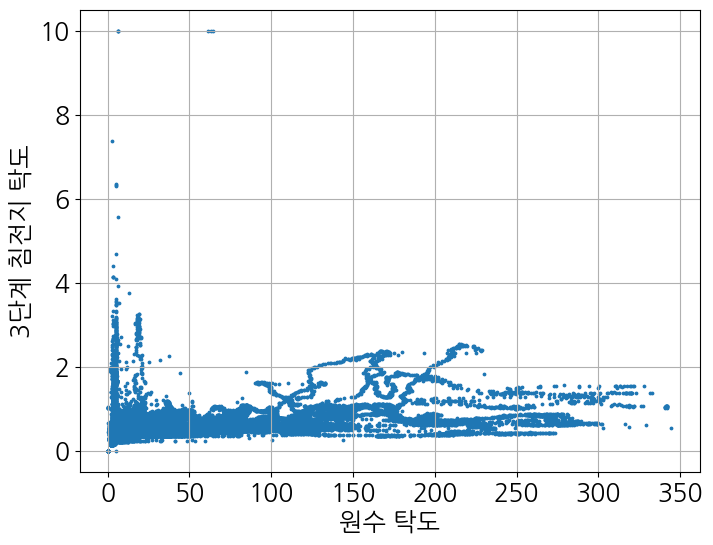

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(raw_df["원수 탁도"], raw_df["3단계 침전지 탁도"], s=3)
plt.grid()
plt.xlabel("원수 탁도")
plt.ylabel("3단계 침전지 탁도")